In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import random
import torchvision.transforms as T
from glob import glob
from tqdm import tqdm
from timm.models.vision_transformer import vit_base_patch16_224
from timm.models.vision_transformer import vit_base_patch32_224
from lightly.models import utils
from lightly.models import utils
from lightly.models.modules import MAEDecoderTIMM, MaskedVisionTransformerTIMM
from lightly.transforms import MAETransform

/rds/general/user/mb1024/home/myenv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision

In [3]:
import timm

In [4]:
from pytorch_msssim import ssim

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch.nn as nn
from lightly.models.modules import MAEDecoderTIMM

class GrayscaleDecoder(MAEDecoderTIMM):
    def __init__(self, num_patches, patch_size, embed_dim, decoder_embed_dim,
                 decoder_depth, decoder_num_heads, mlp_ratio,
                 proj_drop_rate, attn_drop_rate):
        
        # ⚠️ Pass in_chans=1 for grayscale output
        super().__init__(
            num_patches=num_patches,
            patch_size=patch_size,
            in_chans=1,  # 👈 required for grayscale
            embed_dim=embed_dim,
            decoder_embed_dim=decoder_embed_dim,
            decoder_depth=decoder_depth,
            decoder_num_heads=decoder_num_heads,
            mlp_ratio=mlp_ratio,
            proj_drop_rate=proj_drop_rate,
            attn_drop_rate=attn_drop_rate
        )

        # Override the default decoder_pred with 1-channel output
        self.predict = nn.Linear(decoder_embed_dim, patch_size * patch_size * 1)

    def forward(self, x):
        x = self.decode(x)       # inherited from MAEDecoderTIMM
        x = self.predict(x)      # shape: [B, num_masked_patches, patch_dim]
        return x


In [7]:
class MAE(nn.Module):
    def __init__(self, vit):
        super().__init__()

        decoder_dim = 512
        self.mask_ratio = 0.1
        self.patch_size = vit.patch_embed.patch_size[0]

        self.backbone = MaskedVisionTransformerTIMM(vit=vit)
        self.sequence_length = self.backbone.sequence_length
        self.decoder = GrayscaleDecoder(
                num_patches=vit.patch_embed.num_patches,
                patch_size=self.patch_size,
                embed_dim=vit.embed_dim,
                decoder_embed_dim=decoder_dim,
                decoder_depth=1,
                decoder_num_heads=16,
                mlp_ratio=4.0,
                proj_drop_rate=0.0,
                attn_drop_rate=0.0,
            )


    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images=images, idx_keep=idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.decoder.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def forward(self, images, return_full_reconstruction=False):
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
    
        x_encoded = self.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = self.forward_decoder(
            x_encoded=x_encoded, idx_keep=idx_keep, idx_mask=idx_mask
        )
    
        # Patchify original images
        patches = utils.patchify(images, self.patch_size)
    
        # Target: ground truth patches at masked positions
        target = utils.get_at_index(patches, idx_mask - 1)
    
        if return_full_reconstruction:
            # Reconstruct full patch sequence
            recon = patches.clone()  # [B, num_patches, patch_dim]
            recon = utils.set_at_index(recon, idx_mask - 1, x_pred)
    
            return recon, patches  # full recon and original for unpatchify
    
        return x_pred, target


# 1. Create the ViT model
vit = vit_base_patch32_224(pretrained=False)  # or pretrained=True if fine-tuning

# 2. Modify the patch embedding layer to accept 1-channel input
old_proj = vit.patch_embed.proj
vit.patch_embed.proj = nn.Conv2d(
    in_channels=1,  # <--- key change
    out_channels=old_proj.out_channels,
    kernel_size=old_proj.kernel_size,
    stride=old_proj.stride,
    padding=old_proj.padding,
    bias=old_proj.bias is not None
)
device = "cuda" if torch.cuda.is_available() else "cpu"
# 3. Now pass the modified ViT into your MAE model
model = MAE(vit).to(device)



transform = MAETransform()
# we ignore object detection annotations by setting target_transform to return 0


def target_transform(t):
    return 0


In [8]:
final_stack = np.memmap("clean_combined_stack.dat", dtype=np.float32, mode='r', shape=(49402, 204, 216))

In [7]:
# Open the memmap file (already done)
final_stack = np.memmap("clean_combined_stack.dat", dtype=np.float32, mode='r', shape=(49402, 204, 216))

# Randomly choose 1000 unique indices
sample_indices = np.random.choice(final_stack.shape[0], size=1000, replace=False)

# Create a sample array by indexing (this will load only the selected slices)
sample_stack = final_stack[sample_indices]

In [9]:
import torch
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F

class UnlabelledNumpyDataset(Dataset):
    def __init__(self, array_stack, transform=None):
        self.data = array_stack  # shape: [N, H, W]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        arr = self.data[idx].astype(np.float32)

        if np.std(arr) == 0:
            arr += np.random.normal(0, 1e-6, size=arr.shape)

        arr_norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

        img = torch.from_numpy(arr_norm).unsqueeze(0)  # [1, H, W]

        if self.transform:
            img = self.transform(img)

        # Handle single or multi-view transform
        if isinstance(img, list):
            return img, img[0].clone()  # views, original
        else:
            return [img], img.clone() 

In [10]:
import torch.nn.functional as F

class ResizeTensor:
    def __init__(self, size=(224, 224)):
        self.size = size

    def __call__(self, x):
        return F.interpolate(x.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False).squeeze(0)

transform = ResizeTensor((224, 224))

In [11]:
dataset = UnlabelledNumpyDataset(final_stack, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Check a batch
sample = dataset[0]  # First item
views, original = sample

print(f"Type of views: {type(views)}")
print(f"Number of views: {len(views)}")
print(f"Shape of first view: {views[0].shape}")
print(f"Shape of original: {original.shape}")

for views, original in dataloader:
    print(views[0].shape)  # Should be [32, 1, 224, 224]
    print(original.shape)  # Should also be [32, 1, 224, 224]
    break

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim  # make sure you have this installed

class SSIM_MSE_Loss(nn.Module):
    def __init__(self, patch_size=model.patch_size, weight_ssim=0.85):
        super().__init__()
        self.patch_size = patch_size
        self.weight_ssim = weight_ssim

    def forward(self, pred_patches, target_patches):
        """
        pred_patches: [B, num_masked, patch_dim]
        target_patches: [B, num_masked, patch_dim]
        """

        # Unpatchify to full images made of only masked patches
        # Treat each [B, num_masked, patch_dim] as a mini batch of "flattened patches"
        # Reshape to fake image batch: [B * num_masked, 1, patch_size, patch_size]
        B, N, D = pred_patches.shape
        recon = pred_patches.view(-1, 1, self.patch_size, self.patch_size)
        target = target_patches.view(-1, 1, self.patch_size, self.patch_size)

        # SSIM expects values in [0, 1]
        recon = recon.clamp(0, 1)
        target = target.clamp(0, 1)

        ssim_loss = 1 - ssim(recon, target, data_range=1.0, size_average=True)
        mse_loss = F.mse_loss(recon, target)

        # Combine losses
        return self.weight_ssim * ssim_loss + (1 - self.weight_ssim) * mse_loss


Type of views: <class 'list'>
Number of views: 1
Shape of first view: torch.Size([1, 224, 224])
Shape of original: torch.Size([1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])


In [ ]:
criterion = SSIM_MSE_Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)

print("Starting Training")
for epoch in range(25):
    model.train()
    total_loss = 0

    for batch in dataloader:
        views, originals = batch  # views is a list of image views

        # If you're using only one view
        images = views[0].to(device)  # or batch[0].to(device)
        if images.ndim == 3:
            images = images.unsqueeze(1)  # add channel if missing

        #print("Batch shape:", images.shape)  # Debug

        predictions, targets = model(images)
        loss = criterion(predictions, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.detach().item()

    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training


In [ ]:
model.eval()
with torch.no_grad():
    batch = next(iter(dataloader))
    
    # Get the first view and move it to the device
    images = batch[0][0].to(device)

    recon_patches, original_patches = model(images, return_full_reconstruction=True)

    patch_size = model.patch_size
    recon_images = utils.unpatchify(recon_patches, patch_size, channels=1).clamp(0, 1).cpu()
    orig_images = utils.unpatchify(original_patches, patch_size, channels=1).clamp(0, 1).cpu()


In [ ]:
import matplotlib.pyplot as plt

def show_reconstructions(original, reconstructed, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        # Convert from [C, H, W] to [H, W] using only the first channel
        img_orig = original[i][0].detach().cpu().numpy()  # shape: [H, W]
        img_recon = reconstructed[i][0].detach().cpu().numpy()

        axs[0].imshow(img_orig, cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(img_recon, cmap='gray', vmin=0, vmax=1)

        axs[0].set_title("Original")
        axs[1].set_title("Reconstruction")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Example usage:
show_reconstructions(orig_images, recon_images, num_images=5)

In [ ]:
diff = (orig_images - recon_images).abs()
show_reconstructions(diff, diff, num_images=5)  # Just for visualizing error


In [ ]:
import matplotlib.pyplot as plt

def show_difference_maps(original, reconstructed, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))

        orig = original[i].squeeze().cpu().numpy()
        recon = reconstructed[i].squeeze().cpu().numpy()
        diff = abs(orig - recon)

        axs[0].imshow(orig, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title("Original")

        axs[1].imshow(recon, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Reconstruction")

        axs[2].imshow(diff, cmap='hot', vmin=0, vmax=1)
        axs[2].set_title("Difference")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

show_difference_maps(orig_images, recon_images)


In [ ]:
import torch
import torch.nn.functional as F
from lightly.models.utils import random_token_mask, patchify, get_at_index

def print_first_image_masked_patch_diffs(model, dataloader, threshold=0.05):
    model.eval()
    with torch.no_grad():
        # 1) load one batch
        batch = next(iter(dataloader))
        images = batch[0][0].to(device)   # shape [B, 1, H, W]

        B = images.shape[0]
        N = model.sequence_length

        # 2) re-compute the mask exactly as in forward()
        idx_keep, idx_mask = random_token_mask(
            size=(B, N),
            mask_ratio=model.mask_ratio,
            device=images.device
        )

        # 3) run encoder + decoder (no full-forward)
        x_enc = model.forward_encoder(images=images, idx_keep=idx_keep)
        x_pred = model.forward_decoder(x_encoded=x_enc,
                                       idx_keep=idx_keep,
                                       idx_mask=idx_mask)
        # x_pred: [B, N_masked, patch_dim]

        # 4) build ground-truth patches from the original images
        patches = patchify(images, model.patch_size)                # [B, N, patch_dim]
        target = get_at_index(patches, idx_mask - 1)               # [B, N_masked, patch_dim]

        # 5) print only the masked patches of the first image
        image_idx = 0
        for i, patch_idx in enumerate(idx_mask[image_idx]):
            orig_patch = target[image_idx, i].view(model.patch_size, model.patch_size).cpu()
            recon_patch = x_pred[image_idx, i].view(model.patch_size, model.patch_size).cpu()
            diff_patch = (orig_patch - recon_patch).abs()

            print(f"\nMasked Patch {i} (orig idx {patch_idx.item()}):")
            print("Original:\n", orig_patch.numpy())
            print("Reconstruction:\n", recon_patch.numpy())
            print("Difference:\n", diff_patch.numpy())
            if threshold is not None:
                sig = (diff_patch > threshold).numpy()
                print("Significant (>%.2f)?:\n" % threshold, sig)

        # done

print_first_image_masked_patch_diffs(model, dataloader, threshold=0.05)


In [ ]:
print("Image min/max/std:", orig_images[0].min(), orig_images[0].max(), orig_images[0].std())
print("Max pixel difference:", (orig_images[0] - recon_images[0]).abs().max())

Original Patch:
 [[0.20958407 0.20273536 0.19196671 ... 0.14722423 0.14722423 0.14722423]
 [0.23289695 0.22541648 0.22532508 ... 0.14722423 0.14722423 0.14722423]
 [0.23698346 0.2464652  0.25150046 ... 0.14722423 0.14722423 0.14722423]
 ...
 [0.36379367 0.33539593 0.26811457 ... 0.14722423 0.14722423 0.14722423]
 [0.30929333 0.28119618 0.23699147 ... 0.14722423 0.14722423 0.14722423]
 [0.2816503  0.27349547 0.25570482 ... 0.14722423 0.14722423 0.14722423]]
Reconstructed Patch:
 [[0.0450802  0.12803799 0.09713861 ... 0.11671096 0.10220446 0.09234627]
 [0.12994742 0.07568821 0.08414418 ... 0.07583725 0.08153497 0.06298169]
 [0.12146682 0.06339622 0.03480439 ... 0.10631645 0.11968581 0.06660317]
 ...
 [0.09346808 0.13445729 0.11700937 ... 0.08817811 0.13836107 0.13829228]
 [0.07724376 0.07821012 0.10021586 ... 0.09604028 0.06926462 0.11693501]
 [0.13588268 0.10949293 0.06533957 ... 0.09922108 0.12187363 0.07907206]]
Difference:
 [[0.16450387 0.07469738 0.0948281  ... 0.03051327 0.04501978

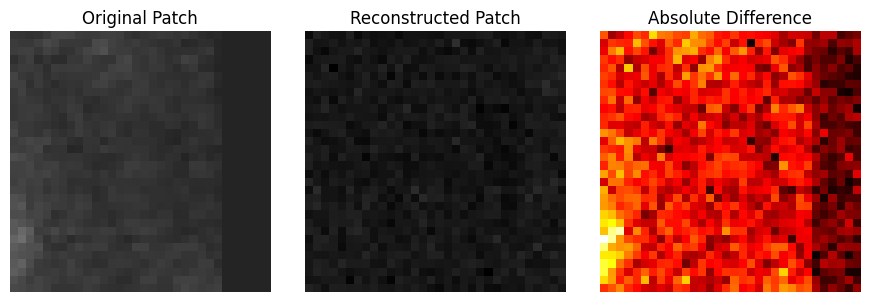

In [89]:
import matplotlib.pyplot as plt

patch_size = model.patch_size

# Get the patches
orig_patch = original_patches[0, 20].view(patch_size, patch_size).cpu()
recon_patch = recon_patches[0, 20].view(patch_size, patch_size).cpu()
diff_patch = (orig_patch - recon_patch).abs()  # absolute difference

# Print the pixel values
print("Original Patch:\n", orig_patch.numpy())
print("Reconstructed Patch:\n", recon_patch.numpy())
print("Difference:\n", diff_patch.numpy())

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(orig_patch.numpy(), cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Original Patch")

axs[1].imshow(recon_patch.numpy(), cmap='gray', vmin=0, vmax=1)
axs[1].set_title("Reconstructed Patch")

axs[2].imshow(diff_patch.numpy(), cmap='hot')
axs[2].set_title("Absolute Difference")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [90]:
import torch.nn.functional as F

# Get first image predictions and targets
pred_0 = predictions[0]  # shape: [num_masked_patches, patch_dim]
target_0 = targets[0]    # same shape

# Compute MSE loss per element (no reduction yet)
mse_per_element = F.mse_loss(pred_0, target_0, reduction="none")

# Average over patch_dim, then over all patches (standard MAE loss)
loss_first_image = mse_per_element.mean()

print("Loss for first image:", loss_first_image.item())


Loss for first image: 0.011371727101504803
